In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import coreset, qaoa

np.random.seed()

In [2]:
import pickle
with open('Datasets/cifar-10-batches-py/data_batch_1', 'rb') as fo:
    d = pickle.load(fo, encoding='bytes')
data_vectors = d[b'data']
labels = d[b'labels']

# filtered_data_vectors = []

# num_trucks, num_frogs, num_deers, num_horses, num_birds = 1000, 10, 10, 10, 10
# for v, l in zip(data_vectors, labels):
#     if l == 2 and num_birds > 0:
#         filtered_data_vectors.append(v.astype('float64'))
#         num_birds -= 1
#     elif l == 4 and num_deers > 0:
#         filtered_data_vectors.append(v.astype('float64'))
#         num_deers -= 1
#     elif l == 6 and num_frogs > 0:
#         filtered_data_vectors.append(v.astype('float64'))
#         num_frogs -= 1
#     elif l == 7 and num_horses > 0:
#         filtered_data_vectors.append(v.astype('float64'))
#         num_horses -= 1
#     elif l == 9 and num_trucks > 0:
#         filtered_data_vectors.append(v.astype('float64'))
#         num_trucks -= 1
        
# data_vectors = filtered_data_vectors
data_vectors = data_vectors - np.mean(data_vectors, axis=0)
np.random.shuffle(data_vectors)

In [3]:
B = coreset.get_bestB(data_vectors, num_runs=10, k=4)

cost_whole = coreset.kmeans_cost(data_vectors, coreset_vectors=data_vectors)
print('cost_whole is %s' % cost_whole)

# random sampling "coreset":
random_sample_5_list = [[data_vectors[i] for i in np.random.choice(len(data_vectors), size=5)] for _ in range(10)]
random_sample_10_list = [[data_vectors[i] for i in np.random.choice(len(data_vectors), size=10)] for _ in range(10)]
random_sample_20_list = [[data_vectors[i] for i in np.random.choice(len(data_vectors), size=20)] for _ in range(10)]
random_sample_40_list = [[data_vectors[i] for i in np.random.choice(len(data_vectors), size=40)] for _ in range(10)]
cost_5_random_list = [coreset.kmeans_cost(data_vectors, coreset_vectors=random_sample_5_list[i]) for i in range(10)]
cost_10_random_list = [coreset.kmeans_cost(data_vectors, coreset_vectors=random_sample_10_list[i]) for i in range(10)]
cost_20_random_list = [coreset.kmeans_cost(data_vectors, coreset_vectors=random_sample_20_list[i]) for i in range(10)]
cost_40_random_list = [coreset.kmeans_cost(data_vectors, coreset_vectors=random_sample_40_list[i]) for i in range(10)]
print('min cost_{5, 10, 20, 40}_random_list is %s, %s, %s, %s' % (
    np.min(cost_5_random_list), np.min(cost_10_random_list), np.min(cost_20_random_list), np.min(cost_40_random_list)))

# actual coreset:
coreset_vectors_5_list, coreset_weights_5_list = [None] * 10, [None] * 10
for i in range(10):
    coreset_vectors_5_list[i], coreset_weights_5_list[i] = coreset.BFL16(data_vectors, B=B, m=5)

coreset_vectors_10_list, coreset_weights_10_list = [None] * 10, [None] * 10
for i in range(10):
    coreset_vectors_10_list[i], coreset_weights_10_list[i] = coreset.BFL16(data_vectors, B=B, m=10)
    
coreset_vectors_20_list, coreset_weights_20_list = [None] * 10, [None] * 10
for i in range(10):
    coreset_vectors_20_list[i], coreset_weights_20_list[i] = coreset.BFL16(data_vectors, B=B, m=20)

coreset_vectors_40_list, coreset_weights_40_list = [None] * 10, [None] * 10
for i in range(10):
    coreset_vectors_40_list[i], coreset_weights_40_list[i] = coreset.BFL16(data_vectors, B=B, m=40)

cost_5_coreset_list = [coreset.kmeans_cost(data_vectors, coreset_vectors=coreset_vectors_5_list[i], sample_weight=coreset_weights_5_list[i]) for i in range(10)]
cost_10_coreset_list = [coreset.kmeans_cost(data_vectors, coreset_vectors=coreset_vectors_10_list[i], sample_weight=coreset_weights_10_list[i]) for i in range(10)]
cost_20_coreset_list = [coreset.kmeans_cost(data_vectors, coreset_vectors=coreset_vectors_20_list[i], sample_weight=coreset_weights_20_list[i]) for i in range(10)]
cost_40_coreset_list = [coreset.kmeans_cost(data_vectors, coreset_vectors=coreset_vectors_40_list[i], sample_weight=coreset_weights_40_list[i]) for i in range(10)]
print('min cost_{5, 10, 20, 40}_coreset_list is %s, %s, %s, %s' % (
    np.min(cost_5_coreset_list), np.min(cost_10_coreset_list), np.min(cost_20_coreset_list), np.min(cost_40_coreset_list)))

best_index = cost_5_coreset_list.index(np.min(cost_5_coreset_list))
best_coreset_vectors = coreset_vectors_5_list[best_index]
best_coreset_weights = coreset_weights_5_list[best_index]
print('\nzeroth order for m=5 coreset:')
qaoa_bound_zero_5 = qaoa.qaoa_bound(best_coreset_vectors, best_coreset_weights, data_vectors, taylor_order=0)

best_index = cost_10_coreset_list.index(np.min(cost_10_coreset_list))
best_coreset_vectors = coreset_vectors_10_list[best_index]
best_coreset_weights = coreset_weights_10_list[best_index]

print('\nzeroth order for m=10 coreset:')
qaoa_bound_zero_10 = qaoa.qaoa_bound(best_coreset_vectors, best_coreset_weights, data_vectors, taylor_order=0)

print('\nfirst order for m=10 coreset:')
qaoa_bound_first_10 = qaoa.qaoa_bound(best_coreset_vectors, best_coreset_weights, data_vectors, taylor_order=1)

print('\nsecond order for m=10 coreset:')
qaoa_bound_second_10 = qaoa.qaoa_bound(best_coreset_vectors, best_coreset_weights, data_vectors, taylor_order=2)

print('\ninfinite order for m=10 coreset:')
qaoa_bound_inf_10 = qaoa.qaoa_bound(best_coreset_vectors, best_coreset_weights, data_vectors, taylor_order='inf')

cost_whole is 100927692864.57724
min cost_{5, 10, 20, 40}_random_list is 129690448673.72505, 116458254715.625, 107163410251.74052, 104610506004.74852
min cost_{5, 10, 20, 40}_coreset_list is 119819943535.19054, 115916241802.9714, 108784522155.23555, 104891879959.59914

zeroth order for m=5 coreset:
148143550411.15604 (-1, 1, -1, -1, -1) 0.34951997306262844 220718605109141.47
145388941349.30325 (1, -1, 1, -1, 1) 1.431261901774021 244916529631036.62
151669530872.0638 (1, 1, -1, 1, -1) 2.2777680748054245 238004003369407.6
119736031709.53761 (1, 1, 1, -1, 1) 5.565416382793504 230253805985400.56
119819943535.19054 (-1, -1, -1, 1, 1) 0.2460698079564185 390269343571238.5

zeroth order for m=10 coreset:
128917208001.86275 (1, 1, 1, 1, 1, 1, -1, 1, 1, 1) 11.309173417728035 334959273247802.3
125529760180.13965 (-1, -1, -1, 1, -1, -1, -1, 1, 1, -1) 0.4450453749625142 188897052864994.47
121012479514.0227 (1, -1, 1, -1, -1, 1, 1, -1, 1, -1) 0.986114767341844 329086228978485.2
118193666299.79938 (-1

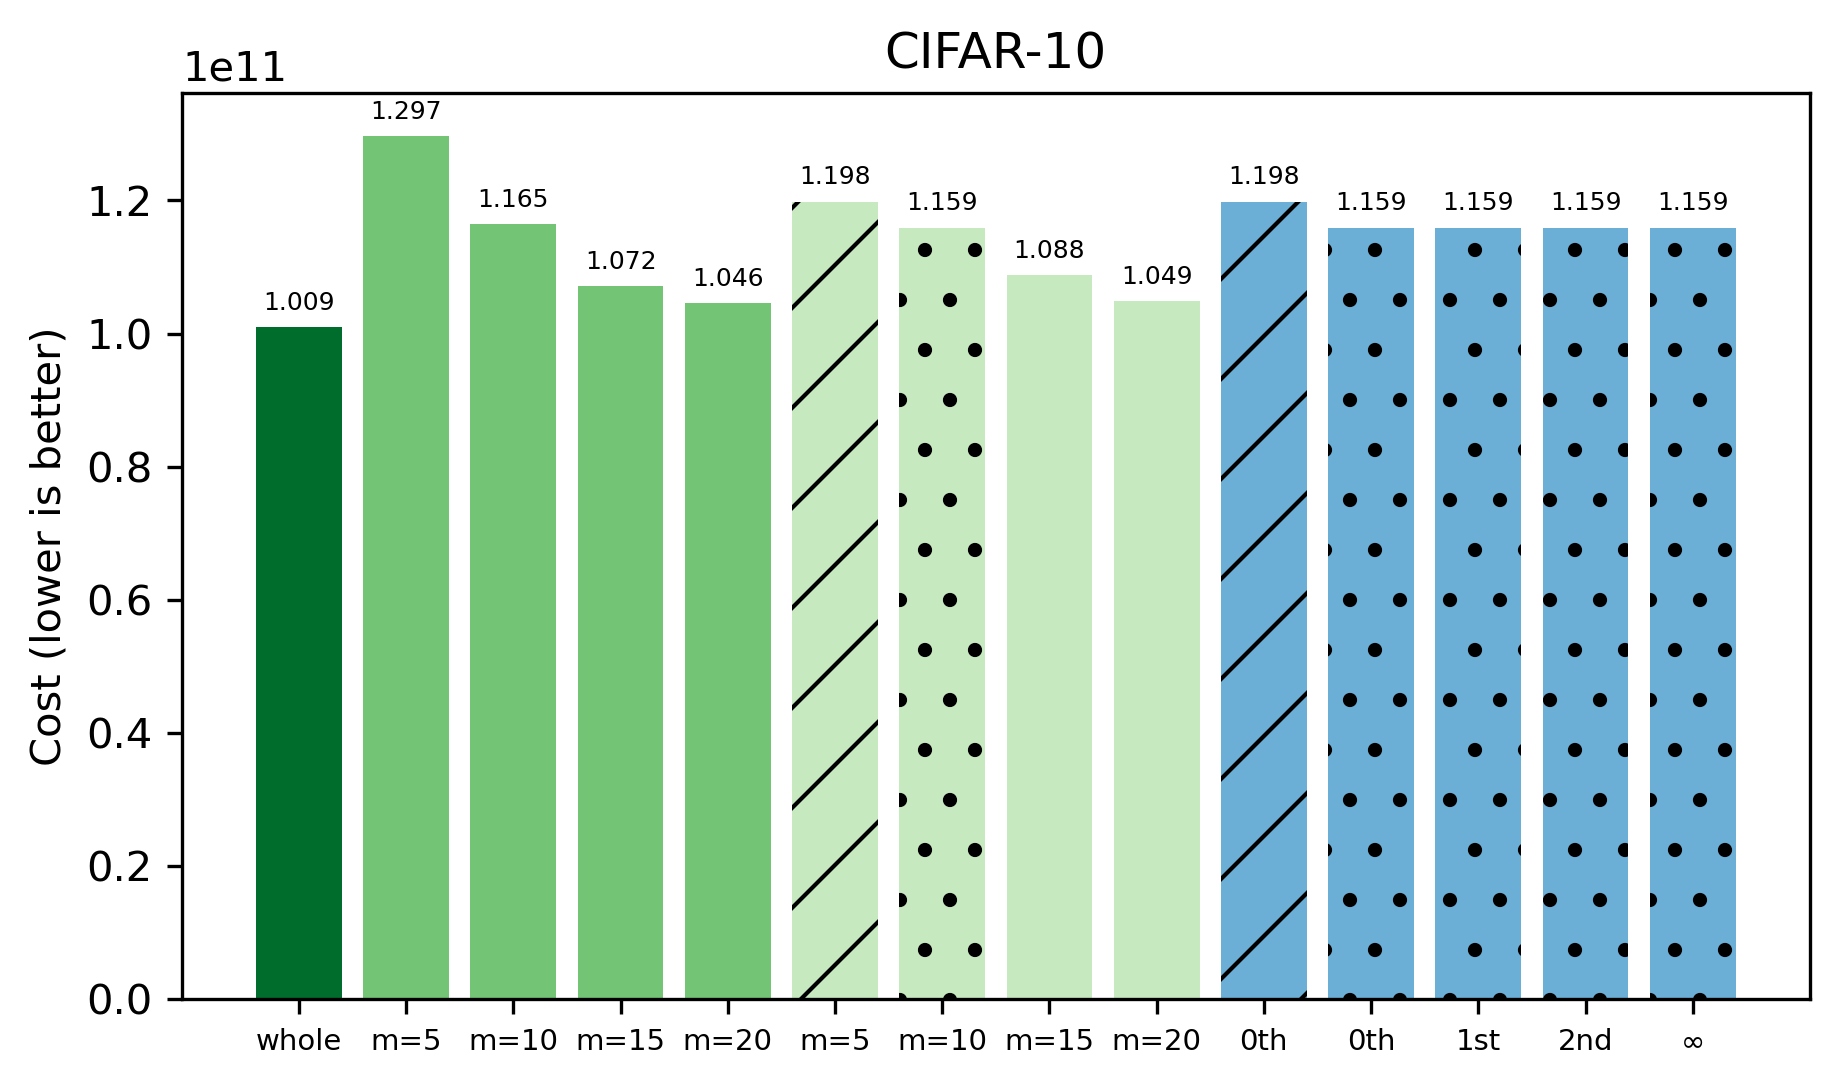

In [5]:
x = np.arange(14)
costs = [cost_whole, np.min(cost_5_random_list), np.min(cost_10_random_list), np.min(cost_20_random_list), np.min(cost_40_random_list),
         np.min(cost_5_coreset_list), np.min(cost_10_coreset_list), np.min(cost_20_coreset_list), np.min(cost_40_coreset_list),
         qaoa_bound_zero_5, qaoa_bound_zero_10, qaoa_bound_first_10, qaoa_bound_second_10, qaoa_bound_inf_10]
scale = np.floor(np.log10(max(costs)))

labels = ['whole', 'm=5', 'm=10', 'm=15', 'm=20', 'm=5', 'm=10', 'm=15', 'm=20', '0th', '0th', '1st', '2nd', u"\u221E"]
color = ['#006d2c', '#74c476', '#74c476', '#74c476', '#74c476', '#c7e9c0', '#c7e9c0', '#c7e9c0', '#c7e9c0', '#6baed6', '#6baed6', '#6baed6', '#6baed6', '#6baed6']
hatch=['', '', '', '', '', '/', '.', '', '', '/', '.', '.', '.', '.']
# plt.bar(x, costs, yerr=yerr, color=color, hatch=hatch)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height() / (10 ** scale)
        ax.annotate('{0:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height * (10 ** scale)),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=6)


fig, ax = plt.subplots(figsize=(7, 4), dpi=300)
for i in range(len(x)):
    rects = ax.bar(x[i], costs[i], label=labels[i], color=color[i], hatch=hatch[i]) # , yerr=[[yerr[0][i]], [yerr[1][i]]])
    autolabel(rects)
    
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=7)
ax.set_ylabel('Cost (lower is better)')
ax.set_title('CIFAR-10')

plt.savefig('cifar10.pdf')

In [6]:
best_index = cost_5_coreset_list.index(np.min(cost_5_coreset_list))
np.save('cifar10_coreset_vectors.npy', coreset_vectors_5_list[best_index])
np.save('cifar10_coreset_weights.npy', coreset_weights_5_list[best_index])